## Carga datos

In [2]:
import pandas as pd
import kglab

In [3]:
NAMESPACES = {
    "wtm":  "http://purl.org/heals/food/",
    "ind":  "http://purl.org/heals/ingredient/",
    "recipe":  "https://www.food.com/recipe/",
    
    "crime": "http://localhost/ontology2#",
    "cube": "http://purl.org/linked-data/cube#",
    "geo": "http://www.w3.org/2003/01/geo/wgs84_pos#",
    "ontology": "http://dbpedia.org/ontology/",
    "owl": "http://www.w3.org/2002/07/owl#",
    "rdf": "http://www.w3.org/1999/02/22-rdf-syntax-ns#",
    "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
    "xsd": "http://www.w3.org/2001/XMLSchema#"
    }

kg = kglab.KnowledgeGraph(namespaces = NAMESPACES)

_ = kg.load_rdf("data/testind3.ttl")

## Algunas metricas

In [4]:
measure = kglab.Measure()
measure.measure_graph(kg)

f"Nodes: {measure.get_node_count()} ; Edges: {measure.get_edge_count()}"

'Nodes: 15697 ; Edges: 144737'

In [ ]:
measure.p_gen.get_tally() # tallies the counts of predicates

In [ ]:
measure.s_gen.get_tally()[:20] # tallies the counts of predicates

In [ ]:
measure.o_gen.get_tally() # tallies the counts of predicates

In [ ]:
measure.l_gen.get_tally() # tallies the counts of literals

## KG como tensor

In [5]:
sg = kglab.SubgraphTensor(kg)

In [6]:
def to_edge_list(g, sg, excludes):
    def exclude(rel):
        return sg.n3fy(rel) in excludes
    
    relations = sorted(set(g.predicates()))
    subjects = set(g.subjects())
    objects = set(g.objects())
    nodes = list(subjects.union(objects))
    
    relations_dict = {rel: i for i, rel in enumerate(list(relations)) if not exclude(rel)}
    
    # this offset enables consecutive indices in our final vector
    offset = len(relations_dict.keys())
    
    nodes_dict = {node: i+offset for i, node in enumerate(nodes)}

    
    edge_list = []
    
    for s, p, o in g.triples((None, None, None)):
        if p in relations_dict.keys(): # this means is not excluded
            src, dst, rel = nodes_dict[s], nodes_dict[o], relations_dict[p]
            edge_list.append([src, dst, 2 * rel])
            edge_list.append([dst, src, 2 * rel + 1])
    
    # turn into str keys and concat
    node_vector = [sg.n3fy(node) for node in relations_dict.keys()] + [sg.n3fy(node) for node in nodes_dict.keys()]
    return edge_list, node_vector

In [7]:
edge_list, node_vector = to_edge_list(kg.rdf_graph(), sg, excludes=['skos:description', 'skos:prefLabel'])

In [8]:
len(edge_list) , edge_list[0:5]

(289474,
 [[8859, 37279, 8],
  [37279, 8859, 9],
  [33373, 9391, 2],
  [9391, 33373, 3],
  [33680, 9377, 2]])

#### Subgrafo para codificar/decodificar ids y uri. Necesario para preparar dataset de entrenamiento y útil para darle sentido a los resultados de la red neuronal

In [9]:
sg = kglab.Subgraph(kg=kg, preload=node_vector)

In [10]:
import torch
from torch_geometric.data import Data

tensor = torch.tensor(edge_list, dtype=torch.long).t().contiguous() 
edge_index, edge_type = tensor[:2], tensor[2]
data = Data(edge_index=edge_index)
data.edge_type = edge_type

c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
(data.edge_index.shape, data.edge_type.shape, data.edge_type.max())

(torch.Size([2, 289474]), torch.Size([289474]), tensor(25))

In [132]:
# LABELS = [
# "http://localhost/VIOLENCIA_FAMILIAR"
# "http://localhost/ROBO_DE_OBJETOS"
# "http://localhost/ROBO_A_NEGOCIO_SIN_VIOLENCIA"
# "http://localhost/AMENAZAS"
# "http://localhost/DENUNCIA_DE_HECHOS"
# "http://localhost/FRAUDE"
# "http://localhost/ROBO_A_TRANSEUNTE_EN_VIA_PUBLICA_CON_VIOLENCIA"
# "http://localhost/ROBO_DE_VEHICULO_DE_SERVICIO_PARTICULAR_SIN_VIOLENCIA"
# "http://localhost/ROBO_A_CASA_HABITACION_SIN_VIOLENCIA"
# "http://localhost/FALSIFICACION_DE_TITULOS_AL_PORTADOR_Y_DOCUMENTOS_DE_CREDITO_PUBLICO"
# "http://localhost/ROBO_DE_OBJETOS_DEL_INTERIOR_DE_UN_VEHICULO"
# "http://localhost/ROBO_DE_ACCESORIOS_DE_AUTO"
# "http://localhost/DAÑO_EN_PROPIEDAD_AJENA_CULPOSA_POR_TRÁNSITO_VEHICULAR_A_AUTOMOVIL"
# "http://localhost/ROBO_A_TRANSEUNTE_DE_CELULAR_CON_VIOLENCIA"
# "http://localhost/ROBO_A_TRANSEUNTE_DE_CELULAR_SIN_VIOLENCIA"
# "http://localhost/DESPOJO"
# "http://localhost/ABUSO_DE_CONFIANZA"
# "http://localhost/LESIONES_CULPOSAS_POR_TRANSITO_VEHICULAR_EN_COLISION"
# "http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA"
# "http://localhost/LESIONES_INTENCIONALES_POR_GOLPES"
# ]



### Preparación de dataset "crudo" de ~recetas~ e ~ingredientes~

In [12]:
# De acuerdo a los datos, deberiamos abordar la clasificación de ¿¿??
# desde el punto de vista de las denuncias o de los crímenes. 

# A clasificar: crime:tieneCategoria
# Atributo: crime:contiene

import pandas as pd
sparql_contiene = """
    SELECT distinct *
    WHERE {
        ?uri a crime:obs .
        ?uri a ?type .   
        ?uri crime:tieneFecha ?definition .
        
        ?uri crime:contiene ?atributo .
        # ?uri crime:edad ?atributo .
        # ?uri crime:genero ?atributo
    }
"""
sparql_edad = """
    SELECT distinct *
    WHERE {
        ?uri a crime:obs .
        ?uri a ?type .   
        ?uri crime:tieneFecha ?definition .
        
        # ?uri crime:contiene ?atributo .
        ?uri crime:edad ?atributo .
        # ?uri crime:genero ?atributo
    }
"""
sparql_genero = """
    SELECT distinct *
    WHERE {
        ?uri a crime:obs .
        ?uri a ?type .   
        ?uri crime:tieneFecha ?definition .
        
        # ?uri crime:contiene ?atributo .
        # ?uri crime:edad ?atributo .
        ?uri crime:genero ?atributo
    }
"""
# Agregar tiene categoria como "ingrediente" o intentar ?lugar como ingrediente
# Cabe la posibilidad de usar "crime:tieneCategoria" en vez de "crime:denuncia"

df_contiene = kg.query_as_df(sparql=sparql_contiene)
df_edad = kg.query_as_df(sparql=sparql_edad)
df_genero = kg.query_as_df(sparql=sparql_genero)

df = pd.concat([df_contiene, df_edad, df_genero], ignore_index=True)

# We group the ingredients into one column containing lists:
denuncias_df = df.groupby(['uri', 'definition', 'type'])['atributo'].apply(list).reset_index(name='atributo')

# si utilizamos categoria, tenemos información de horas y coordenadas
sparql_serializado = """
    SELECT distinct *
    WHERE {
        ?uri a crime:obs .
        ?uri a ?type .
        # OPTIONAL { ?uri crime:ocurrioEn ?definition } 
        OPTIONAL { ?uri crime:tieneCategoria ?definition } 
    }
"""

type_crime_df = kg.query_as_df(sparql=sparql_serializado)
type_crime_df['atributo'] = None

crimes_df = pd.concat([denuncias_df, type_crime_df]).reset_index(drop=True)

crimes_df.fillna('', inplace=True) ; crimes_df

,uri,definition,type,atributo
0,<http://localhost/100091>,2019-06-05,crime:obs,[<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_...
1,<http://localhost/100124>,2019-02-10,crime:obs,"[<http://localhost/VIOLENCIA_FAMILIAR>, 38.0, ..."
2,<http://localhost/10020>,2019-06-02,crime:obs,[<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCI...
3,<http://localhost/100449>,2019-05-18,crime:obs,[<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCI...
4,<http://localhost/100505>,2019-06-07,crime:obs,[<http://localhost/ROBO_DE_VEHICULO_DE_SERVICI...
...,...,...,...,...
27990,<http://localhost/99795>,<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_M...,crime:obs,
27991,<http://localhost/99803>,<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚB...,crime:obs,
27992,<http://localhost/99881>,<http://localhost/VIOLACIÓN>,crime:obs,
27993,<http://localhost/9992>,<http://localhost/ROBO_A_CUENTAHABIENTE_SALIEN...,crime:obs,


In [16]:
## EXTRA: Necesitamos este "type" extra? --> crime:obs
# Antes
crimes_df.shape # (19997, 4)

(27995, 4)

In [17]:
# Contemos uris para saber si hay duplicados
crimes_df.groupby(["uri"]).count()[crimes_df.groupby(["uri"]).count()["definition"] < 2]

,definition,type,atributo
uri,,,
<http://localhost/172838>,1,1,1
<http://localhost/225410>,1,1,1
<http://localhost/263821>,1,1,1
<http://localhost/263857>,1,1,1
<http://localhost/805456>,1,1,1


In [18]:
crimes_df[crimes_df["uri"] == "<http://localhost/172838>"]

,uri,definition,type,atributo
15627,<http://localhost/172838>,<http://localhost/HECHO_NO_DELICTIVO>,crime:obs,


### CONCLUSIÓN: NO HAY DUPLICADOS COMO EN EL ANTERIOR DATASET PERO HAY TRES REGISTROS QUE CUYA ENTRADA "crime:tieneFecha" no es válida --> crime:tieneFecha "NaN"^^xsd:double

#### ACCIÓN: Se eliminaran tales registros por el momento

In [19]:
valid_rows = (crimes_df["uri"] != "<http://localhost/172838>") & \
             (crimes_df["uri"] != "<http://localhost/225410>") & \
             (crimes_df["uri"] != "<http://localhost/263821>") & \
             (crimes_df["uri"] != "<http://localhost/263857>") & \
             (crimes_df["uri"] != "<http://localhost/805456>")
crimes_df = crimes_df[valid_rows]

In [20]:
crimes_df.count()

uri           27990
definition    27990
type          27990
atributo      27990
dtype: int64

In [21]:
LABELS = list(type_crime_df['definition'].unique())

In [22]:
LABELS

['<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
 '<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>',
 '<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_TAXI_CON_VIOLENCIA>',
 '<http://localhost/ROBO_A_CUENTAHABIENTE_SALIENDO_DEL_CAJERO_CON_VIOLENCIA>',
 '<http://localhost/HOMICIDIO_DOLOSO>',
 '<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/VIOLACIÓN>',
 '<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>',
 '<http://localhost/HECHO_NO_DELICTIVO>',
 '<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>',
 '<http://localhost/ROBO_A_CASA_HABITACIÓN_CON_VIOLENCIA>',
 '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>']

In [23]:
# LABELS = [float('nan'),
#  '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
#  '<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>',
#  '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>',
#  '<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>',
#  '<http://localhost/HECHO_NO_DELICTIVO>',
#  '<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>',
#  '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>',
#  '<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>',
#  '<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>',
#  '<http://localhost/ROBO_A_CUENTAHABIENTE_SALIENDO_DEL_CAJERO_CON_VIOLENCIA>',
#  '<http://localhost/HOMICIDIO_DOLOSO>',
#  '<http://localhost/ROBO_A_CASA_HABITACIÓN_CON_VIOLENCIA>',
#  '<http://localhost/VIOLACIÓN>',
#  '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_TAXI_CON_VIOLENCIA>',
#  '<http://localhost/ROBO_A_TRANSPORTISTA_CON_Y_SIN_VIOLENCIA>',
#  '<http://localhost/SECUESTRO>']

# # LABELS

### Se guarda el proceso de la manipulación de datos en un CSV de ambos datasets

In [24]:
# Se quitan las filas repetidas --> crime:obs & crime:Denuncia
# valid_rows = denuncias_df["type"] != "crime:obs" # Innecesario puesto que no tenemos 2 types
# denuncias_df = denuncias_df[valid_rows]
denuncias_df.to_csv("data/denuncias_raw.csv")

In [25]:
type_crime_df.to_csv("data/type_crime_raw.csv")

### Se guarda el dataset consolidado de denuncias y crímenes

In [26]:
crimes_df.to_csv("data/graph_to_table.csv")

### CHECKPOINT #1: Se carga el CSV con puras denuncias para solo el etiquetado que después se usará en el model de aprendizaje supervisado. ESTO TIENE QUE SER LLEVADO A CABO DE OTRA FORMA

In [27]:
denuncias_df = pd.read_csv("data/denuncias_raw.csv")
type_crime_df = pd.read_csv("data/type_crime_raw.csv")

In [28]:
denuncias_df.head(3)

,Unnamed: 0,uri,definition,type,atributo
0,0,<http://localhost/100091>,2019-06-05,crime:obs,['<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE...
1,1,<http://localhost/100124>,2019-02-10,crime:obs,"['<http://localhost/VIOLENCIA_FAMILIAR>', 38.0..."
2,2,<http://localhost/10020>,2019-06-02,crime:obs,['<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENC...


In [29]:
type_crime_df.head(3)

,Unnamed: 0,type,uri,definition,atributo
0,0,crime:obs,<http://localhost/100091>,<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_M...,NaN
1,1,crime:obs,<http://localhost/100124>,<http://localhost/DELITO_DE_BAJO_IMPACTO>,NaN
2,2,crime:obs,<http://localhost/10020>,<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>,NaN


### Con el fin de etiquetar el dataset de denuncias y por cuestiones prácticas, se hace un join entre la tabla de denuncias y la de crimenes para asignarle una categoría. OTRA VEZ, ESTO TIENE QUE HACERSE DE OTRA FORMA

In [32]:
# # Se extraen el unico atributo para dejarlo como un string y no como una lista de strings 
# denuncias_df["atributo"] = denuncias_df["atributo"].apply(lambda x: x.split("'")[1])

In [30]:
denuncias_labeled = pd.merge(denuncias_df, type_crime_df[["uri", "definition"]], left_on="uri", right_on="uri", how='left')

In [31]:
# Deberiamos de seguir considerando "crime:tieneCategoria"??
denuncias_labeled

,Unnamed: 0,uri,definition_x,type,atributo,definition_y
0,0,<http://localhost/100091>,2019-06-05,crime:obs,['<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE...,<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_M...
1,1,<http://localhost/100124>,2019-02-10,crime:obs,"['<http://localhost/VIOLENCIA_FAMILIAR>', 38.0...",<http://localhost/DELITO_DE_BAJO_IMPACTO>
2,2,<http://localhost/10020>,2019-06-02,crime:obs,['<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENC...,<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>
3,3,<http://localhost/100449>,2019-05-18,crime:obs,['<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENC...,<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>
4,4,<http://localhost/100505>,2019-06-07,crime:obs,['<http://localhost/ROBO_DE_VEHICULO_DE_SERVIC...,<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_V...
...,...,...,...,...,...,...
13990,13990,<http://localhost/99795>,2019-10-05,crime:obs,['<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE...,<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_M...
13991,13991,<http://localhost/99803>,2019-10-05,crime:obs,['<http://localhost/ROBO_A_TRANSEUNTE_EN_VIA_P...,<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚB...
13992,13992,<http://localhost/99881>,2019-10-06,crime:obs,"['<http://localhost/VIOLACION>', 20.0, 'Femeni...",<http://localhost/VIOLACIÓN>
13993,13993,<http://localhost/9992>,2019-06-03,crime:obs,['<http://localhost/ROBO_A_TRANSEUNTE_SALIENDO...,<http://localhost/ROBO_A_CUENTAHABIENTE_SALIEN...


In [89]:
# del denuncias_labeled["uri_y"]

In [32]:
# se renombran las columnas necesarias
denuncias_labeled = denuncias_labeled.rename(
    columns={
        "definition_x": "definition",
        "definition_y": "labels"
    })

In [33]:
denuncias_labeled.head(3)

,Unnamed: 0,uri,definition,type,atributo,labels
0,0,<http://localhost/100091>,2019-06-05,crime:obs,['<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE...,<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_M...
1,1,<http://localhost/100124>,2019-02-10,crime:obs,"['<http://localhost/VIOLENCIA_FAMILIAR>', 38.0...",<http://localhost/DELITO_DE_BAJO_IMPACTO>
2,2,<http://localhost/10020>,2019-06-02,crime:obs,['<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENC...,<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>


In [34]:
# Convirtiendo nuevamente las "labels" como una lista
denuncias_labeled["labels"] = denuncias_labeled["labels"].apply(lambda x: [f"{x}"])

In [35]:
denuncias_labeled.head(3)

,Unnamed: 0,uri,definition,type,atributo,labels
0,0,<http://localhost/100091>,2019-06-05,crime:obs,['<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE...,[<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_...
1,1,<http://localhost/100124>,2019-02-10,crime:obs,"['<http://localhost/VIOLENCIA_FAMILIAR>', 38.0...",[<http://localhost/DELITO_DE_BAJO_IMPACTO>]
2,2,<http://localhost/10020>,2019-06-02,crime:obs,['<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENC...,[<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>]


## Let's count the categories

In [36]:
conteo_categorias = denuncias_labeled['labels'].apply(lambda x: x[0]).value_counts(normalize=False)
conteo_categorias

<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>    1000
<http://localhost/DELITO_DE_BAJO_IMPACTO>                                     1000
<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>                               1000
<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>                       1000
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_TAXI_CON_VIOLENCIA>              1000
<http://localhost/HOMICIDIO_DOLOSO>                                           1000
<http://localhost/VIOLACIÓN>                                                  1000
<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>              1000
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>      1000
<http://localhost/ROBO_A_CUENTAHABIENTE_SALIENDO_DEL_CAJERO_CON_VIOLENCIA>     999
<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>        999
<http://localhost/HECHO_NO_DELICTIVO>                                          999
<htt

In [37]:
denuncias_labeled['labels'].apply(lambda x: x[0]).value_counts(normalize=True) * 100

<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>    7.145409
<http://localhost/DELITO_DE_BAJO_IMPACTO>                                     7.145409
<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>                               7.145409
<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>                       7.145409
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_TAXI_CON_VIOLENCIA>              7.145409
<http://localhost/HOMICIDIO_DOLOSO>                                           7.145409
<http://localhost/VIOLACIÓN>                                                  7.145409
<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>              7.145409
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>      7.145409
<http://localhost/ROBO_A_CUENTAHABIENTE_SALIENDO_DEL_CAJERO_CON_VIOLENCIA>    7.138264
<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>       7.138264
<http://localhost/HECHO_NO_DELICTIVO>      

## Removemos los registros cuyo conteo de categoria sea menor a 2 (Necesario para el "strtify" en train_test_split method)

In [38]:
for categoria, conteo in conteo_categorias.items():
    if conteo < 2:
        valid_rows = denuncias_labeled['labels'].apply(lambda x: x[0]) != categoria
        denuncias_labeled = denuncias_labeled[valid_rows]

In [39]:
denuncias_labeled['labels'].apply(lambda x: x[0]).value_counts(normalize=False)

<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>    1000
<http://localhost/DELITO_DE_BAJO_IMPACTO>                                     1000
<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>                               1000
<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>                       1000
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_TAXI_CON_VIOLENCIA>              1000
<http://localhost/HOMICIDIO_DOLOSO>                                           1000
<http://localhost/VIOLACIÓN>                                                  1000
<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>              1000
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>      1000
<http://localhost/ROBO_A_CUENTAHABIENTE_SALIENDO_DEL_CAJERO_CON_VIOLENCIA>     999
<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>        999
<http://localhost/HECHO_NO_DELICTIVO>                                          999
<htt

In [40]:
# Se splitea el dataset
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(denuncias_labeled, stratify=denuncias_labeled['labels'])

## Verificamos que haya una proporcion similar respecto al dataset maestro (denuncias_labeled)

In [41]:
train_df['labels'].apply(lambda x: x[0]).value_counts(normalize=True) * 100

<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>      7.145579
<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>                               7.145579
<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>              7.145579
<http://localhost/HOMICIDIO_DOLOSO>                                           7.145579
<http://localhost/DELITO_DE_BAJO_IMPACTO>                                     7.145579
<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>                       7.145579
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_TAXI_CON_VIOLENCIA>              7.145579
<http://localhost/ROBO_A_CUENTAHABIENTE_SALIENDO_DEL_CAJERO_CON_VIOLENCIA>    7.145579
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>    7.145579
<http://localhost/VIOLACIÓN>                                                  7.145579
<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>                      7.136052
<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_

In [42]:
test_df['labels'].apply(lambda x: x[0]).value_counts(normalize=True) * 100

<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>                       7.144899
<http://localhost/DELITO_DE_BAJO_IMPACTO>                                     7.144899
<http://localhost/HOMICIDIO_DOLOSO>                                           7.144899
<http://localhost/ROBO_A_CASA_HABITACIÓN_CON_VIOLENCIA>                       7.144899
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>      7.144899
<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>              7.144899
<http://localhost/HECHO_NO_DELICTIVO>                                         7.144899
<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>    7.144899
<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>                      7.144899
<http://localhost/VIOLACIÓN>                                                  7.144899
<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>                               7.144899
<http://localhost/ROBO_A_PASAJERO_A_BORDO_D

### Con el fines lúdicos, se le asgina como vacío a la columna de labels del DATASET DE PRUEBA.
#### Cambio: El ejercicio de las recetas sí usa las etiquetas en el dataset de prueba

In [222]:
# test_df["labels"] = None

In [43]:
train_df.head(3)

,Unnamed: 0,uri,definition,type,atributo,labels
7321,7321,<http://localhost/503363>,2021-02-10,crime:obs,['<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE...,[<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL...
8958,8958,<http://localhost/61019>,2019-04-27,crime:obs,['<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENC...,[<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>]
13001,13001,<http://localhost/890504>,2022-09-01,crime:obs,['<http://localhost/LESIONES_INTENCIONALES_POR...,[<http://localhost/LESIONES_DOLOSAS_POR_DISPAR...


In [44]:
test_df.head(3)

,Unnamed: 0,uri,definition,type,atributo,labels
5858,5858,<http://localhost/407947>,2020-09-02,crime:obs,['<http://localhost/ROBO_DE_MOTOCICLETA_CON_VI...,[<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_...
3189,3189,<http://localhost/248876>,2019-03-13,crime:obs,['<http://localhost/ROBO_A_TRANSEUNTE_SALIENDO...,[<http://localhost/ROBO_A_CUENTAHABIENTE_SALIE...
4587,4587,<http://localhost/329666>,2019-10-23,crime:obs,"['<http://localhost/FRAUDE>', 'No especificado...",[<http://localhost/DELITO_DE_BAJO_IMPACTO>]


In [45]:
# Se guardan los datasets
train_df.to_csv("data/train_tables.csv")
test_df.to_csv("data/test_table.csv")
denuncias_labeled.to_csv("data/clean_denuncias_labeled.csv", index=False)

In [46]:
df = pd.read_csv("data/graph_to_table.csv")

In [227]:
# # ESTO NO ES NECESARIO PARA NUESTRO EJERCICIO PUESTO QUE SE TIENE QUE HACEER UNA LABOR
# # DE ETIQUETADO POR LO QUE NO EL GUARDARLO Y CARGARLO SIN ETIQUETAS ES INÚTIL.
# USAR data/train_tables.csv Y data/test_tables.csv

# from sklearn.model_selection import train_test_split

# train_df, test_df = train_test_split(df)
# train_df.to_csv('data/train_table_new.csv')
# test_df.to_csv('data/test_table_new.csv')

## Checkpoint 2: Se cargan los dataset YA etiquetados

In [47]:
denuncias_labeled = pd.read_csv("data/clean_denuncias_labeled.csv")
train_df = pd.read_csv('data/train_tables.csv') # use your own labelled datasets if you've created a snapshot
test_df = pd.read_csv('data/test_table.csv')

train_df.labels = train_df.labels.apply(eval)
test_df.labels = test_df.labels.apply(eval)

In [48]:
train_df.head()

,Unnamed: 0,Unnamed: 0.1,uri,definition,type,atributo,labels
0,7321,7321,<http://localhost/503363>,2021-02-10,crime:obs,['<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE...,[<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL...
1,8958,8958,<http://localhost/61019>,2019-04-27,crime:obs,['<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENC...,[<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>]
2,13001,13001,<http://localhost/890504>,2022-09-01,crime:obs,['<http://localhost/LESIONES_INTENCIONALES_POR...,[<http://localhost/LESIONES_DOLOSAS_POR_DISPAR...
3,11905,11905,<http://localhost/815230>,2022-05-19,crime:obs,['<http://localhost/HOMICIDIO_POR_ARMA_DE_FUEG...,[<http://localhost/HOMICIDIO_DOLOSO>]
4,111,111,<http://localhost/105418>,2018-12-28,crime:obs,['<http://localhost/ROBO_A_REPARTIDOR_CON_VIOL...,[<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN...


### Let's create label lookups for label to int and viceversa

In [49]:
LABELS = list(denuncias_labeled["labels"].apply(lambda x: eval(x)[0]).unique())

In [50]:
label2id = {label:i for i,label in enumerate(LABELS)}
id2label = {i:l for l,i in label2id.items()} ; (id2label, label2id)

({0: '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>',
  1: '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
  2: '<http://localhost/ROBO_A_NEGOCIO_CON_VIOLENCIA>',
  3: '<http://localhost/ROBO_DE_VEHÍCULO_CON_Y_SIN_VIOLENCIA>',
  4: '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_TAXI_CON_VIOLENCIA>',
  5: '<http://localhost/ROBO_A_CUENTAHABIENTE_SALIENDO_DEL_CAJERO_CON_VIOLENCIA>',
  6: '<http://localhost/HOMICIDIO_DOLOSO>',
  7: '<http://localhost/ROBO_A_TRANSEUNTE_EN_VÍA_PÚBLICA_CON_Y_SIN_VIOLENCIA>',
  8: '<http://localhost/VIOLACIÓN>',
  9: '<http://localhost/LESIONES_DOLOSAS_POR_DISPARO_DE_ARMA_DE_FUEGO>',
  10: '<http://localhost/HECHO_NO_DELICTIVO>',
  11: '<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>',
  12: '<http://localhost/ROBO_A_CASA_HABITACIÓN_CON_VIOLENCIA>',
  13: '<http://localhost/ROBO_A_PASAJERO_A_BORDO_DEL_METRO_CON_Y_SIN_VIOLENCIA>'},
 {'<http://localhost/ROBO_A_PASAJERO_A_BORDO_DE_MICROBUS_CON_Y_SIN_VIOLENCIA>': 0,
  '<http://lo

### The following function turns our DataFrame into numerical arrays for node indices and labels

In [51]:
import torch
from torch_geometric.data import Data
import numpy as np

def create_indices_labels(df):
    # turn our dense labels into a one-hot list
    def one_hot(label_ids):
        a = np.zeros(len(LABELS))
        a.put(label_ids, np.ones(len(label_ids)))
        return a
    
    indices, labels = [], []
    for uri, label in zip(df.uri.tolist(), df.labels.tolist()):
        indices.append(sg.transform(uri))
        labels.append(one_hot([label2id[label] for label in label]))
    return indices, labels

In [52]:
train_indices, train_labels = create_indices_labels(train_df)
test_indices, test_labels = create_indices_labels(test_df)

train_idx = torch.tensor(train_indices, dtype=torch.long)
train_y = torch.tensor(train_labels, dtype=torch.float)

test_idx = torch.tensor(test_indices, dtype=torch.long)
test_y = torch.tensor(test_labels, dtype=torch.float) ; train_idx[:10], train_y

(tensor([40011, 11116, 16999,  6881, 31498, 27471, 10037, 12508, 23537,  2160]),
 tensor([[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

### Corroborando que se tengan todas las categorias en los arrays numéricos

In [53]:
len(np.unique(test_labels, axis=0))

14

In [54]:
indx = 100
(train_df.loc[indx], sg.inverse_transform(train_idx[indx]))

(Unnamed: 0                                                   7120
 Unnamed: 0.1                                                 7120
 uri                                     <http://localhost/491127>
 definition                                             2021-01-21
 type                                                    crime:obs
 atributo        ['<http://localhost/ROBO_A_TRANSEUNTE_SALIENDO...
 labels          [<http://localhost/ROBO_A_CUENTAHABIENTE_SALIE...
 Name: 100, dtype: object,
 '<http://localhost/491127>')

## Creando un subgrafo de nodos para "recetas" e "ingredientes"

In [55]:
node_idx = torch.LongTensor([
    sg.transform(i) for i in crimes_df.uri.values
])

In [56]:
node_idx.max(), node_idx.shape

(tensor(40850), torch.Size([27990]))

In [57]:
crimes_df.iloc[1]

uri                                   <http://localhost/100124>
definition                                           2019-02-10
type                                                  crime:obs
atributo      [<http://localhost/VIOLENCIA_FAMILIAR>, 38.0, ...
Name: 1, dtype: object

In [58]:
sg.inverse_transform(node_idx[1])

'<http://localhost/100124>'

In [59]:
node_idx[0:10]

tensor([26060, 13577, 40415, 13309,  5960, 27168, 12747, 22016, 13754,  8814])

## Clasificación semi-supervisada

In [60]:
from torch_geometric.utils import k_hop_subgraph
# here we take all connected nodes with k hops
k = 1
# The method returns 
# (1) the nodes involved in the subgraph,
# (2) the filtered edge_index connectivity, 
# (3) the mapping from node indices in node_idx to their new location, and 
# (4) the edge mask indicating which edges were preserved.
node_idx, edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx, 
    k, 
    data.edge_index, 
    relabel_nodes=False
)

In [99]:
len(edge_mask)

289474

In [61]:
removed_nodes_indx = []
for m, preserved_node in enumerate(edge_mask):
    if not preserved_node:
        # print(m, preserved_node)
        removed_nodes_indx.append(m)
len(removed_nodes_indx)

6584

In [62]:
len(removed_nodes_indx)

6584

In [63]:
# Let's use another tensor
data_removed_nodes_by_subgraph = data.clone()

In [64]:
shape_graph = data_removed_nodes_by_subgraph.edge_index.shape

In [65]:
shape_graph

torch.Size([2, 289474])

In [66]:
edge_mask_reshaped = edge_mask.repeat(shape_graph[0], 1)

In [67]:
# reshape according with data returned by the k_hops model
# edge_index
data_removed_nodes_by_subgraph.edge_index = data_removed_nodes_by_subgraph.edge_index[edge_mask_reshaped].view(edge_index.shape)
data_removed_nodes_by_subgraph.edge_type = data_removed_nodes_by_subgraph.edge_type[edge_mask]

In [68]:
data_removed_nodes_by_subgraph

Data(edge_index=[2, 282890], edge_type=[282890])

In [69]:
edge_index.shape # SHALL WE REMOVE THE UNLINKED NODES? a: YES --> Remove them using edge_mask object

torch.Size([2, 282890])

In [70]:
node_idx.shape

torch.Size([40759])

In [71]:
## Algunas metricas para el modelo
data_removed_nodes_by_subgraph.edge_index = edge_index

data_removed_nodes_by_subgraph.num_nodes = data_removed_nodes_by_subgraph.edge_index.max().item() + 1

data_removed_nodes_by_subgraph.num_relations = data_removed_nodes_by_subgraph.edge_type.max().item() + 1

# This is already done by our process
# data_removed_nodes_by_subgraph.edge_type = data_removed_nodes_by_subgraph.edge_type[edge_mask]

data_removed_nodes_by_subgraph.num_classes = len(LABELS)

data_removed_nodes_by_subgraph.num_nodes, data_removed_nodes_by_subgraph.num_relations, data_removed_nodes_by_subgraph.num_classes

(40854, 26, 14)

### Definición de una RGCN

In [73]:
from torch_geometric.nn import FastRGCNConv, RGCNConv
import torch.nn.functional as F

In [74]:
class RGCN(torch.nn.Module):
    def __init__(self, num_nodes, num_relations, num_classes, out_channels=16, num_bases=30, dropout=0.0, layer_type=FastRGCNConv, ):
        
        super(RGCN, self).__init__()
        
        self.conv1 = layer_type(
            num_nodes, 
            out_channels, 
            num_relations, 
            num_bases=num_bases
        )
        self.conv2 = layer_type(
            out_channels, 
            num_classes, 
            num_relations, 
            num_bases=num_bases
        )
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, edge_index, edge_type):
        x = F.relu(self.conv1(None, edge_index, edge_type))
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_type)
        return torch.sigmoid(x)

### Visualización del modelo

In [75]:
model = RGCN(
    num_nodes=data_removed_nodes_by_subgraph.num_nodes,
    num_relations=data_removed_nodes_by_subgraph.num_relations,
    num_classes=data_removed_nodes_by_subgraph.num_classes,
    #out_channels=64,
    dropout=0.2,
    layer_type=RGCNConv
) ; model

RGCN(
  (conv1): RGCNConv(40854, 16, num_relations=26)
  (conv2): RGCNConv(16, 14, num_relations=26)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [76]:
# code adapted from https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pytorch_lightning.metrics.utils import to_categorical

def visualize(h, color, labels):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    legend = plt.legend(scatter.legend_elements()[0],labels, loc="upper right", title="Labels",) #*scatter.legend_elements()
    plt.show()

In [77]:
edge_index.shape

torch.Size([2, 282890])

In [78]:
edge_type.shape

torch.Size([289474])

In [79]:
edge_type[edge_mask].shape

torch.Size([282890])

In [80]:
# pred = model(edge_index, edge_type)
pred = model(edge_index, edge_type[edge_mask])

## Mostrando la clasificación del modelo antes de entrenamiento

c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


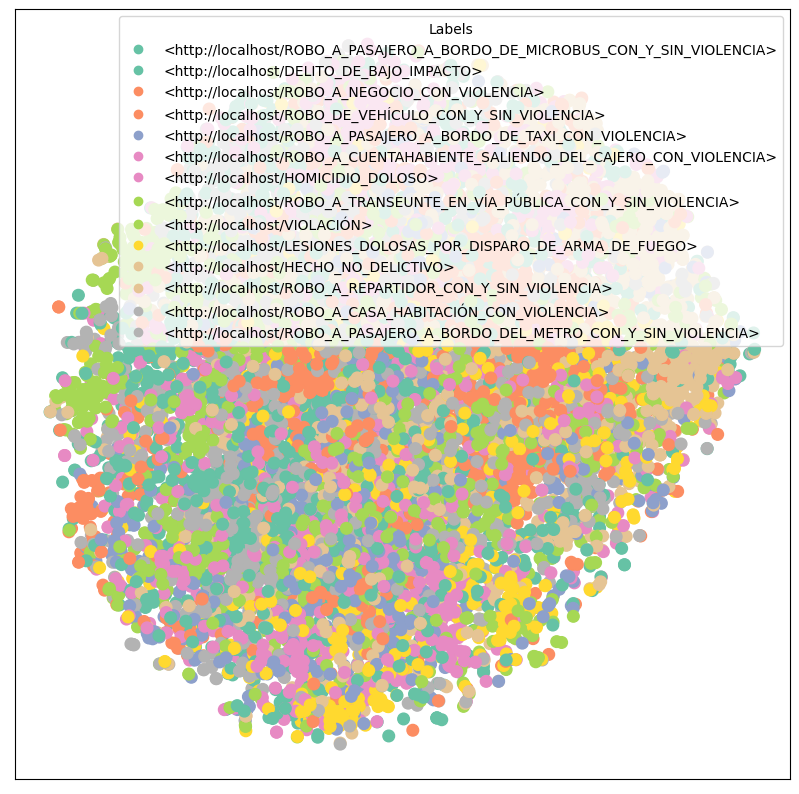

In [81]:
visualize(pred[train_idx], color=to_categorical(train_y), labels=LABELS)
# visualize(pred[train_idx], labels=LABELS)

c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


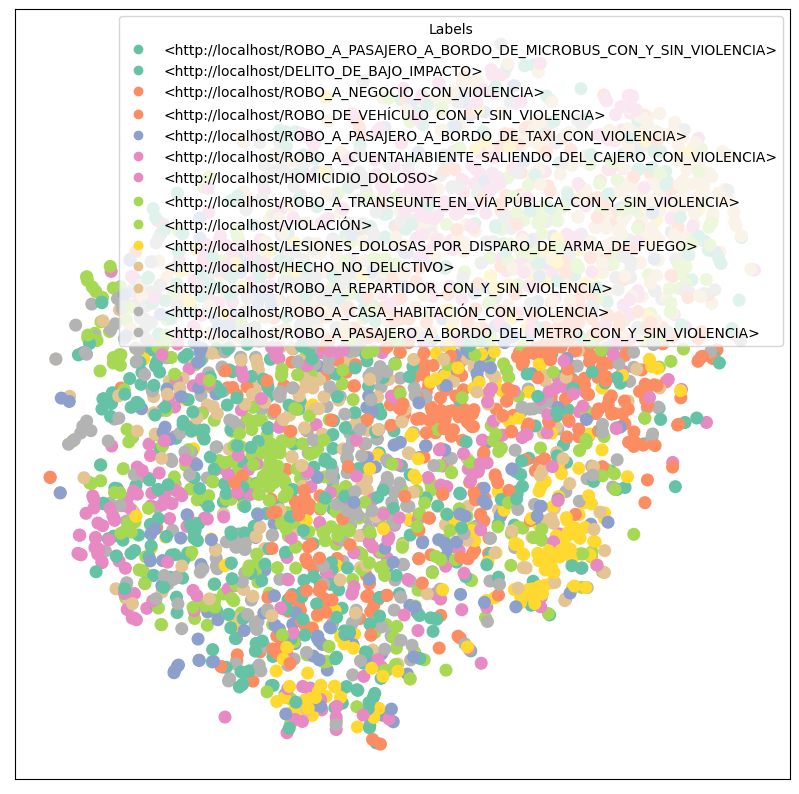

In [82]:
visualize(pred[test_idx], color=to_categorical(test_y), labels=LABELS)

### Entrena la RGCN

In [83]:
device = torch.device('cpu') # ('cuda')
data_device = data_removed_nodes_by_subgraph.to(device)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters())
loss_module = torch.nn.BCELoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data_device.edge_index, data_device.edge_type)
    loss = loss_module(out[train_idx], train_y)
    loss.backward()
    optimizer.step()
    return loss.item()

def accuracy(predictions, y):
    predictions = np.round(predictions)
    return predictions.eq(y).to(torch.float).mean()

@torch.no_grad()
def test():
    model.eval()
    pred = model(data_device.edge_index, data_device.edge_type)
    train_acc = accuracy(pred[train_idx], train_y)
    test_acc = accuracy(pred[test_idx], test_y)
    return train_acc.item(), test_acc.item()

In [84]:
for epoch in range(1, 50):
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f} '
          f'Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.6921, Train: 0.8373 Test: 0.8175
Epoch: 02, Loss: 0.6760, Train: 0.8551 Test: 0.8407
Epoch: 03, Loss: 0.6609, Train: 0.8552 Test: 0.8441
Epoch: 04, Loss: 0.6442, Train: 0.8583 Test: 0.8485
Epoch: 05, Loss: 0.6274, Train: 0.8621 Test: 0.8532
Epoch: 06, Loss: 0.6100, Train: 0.8664 Test: 0.8579
Epoch: 07, Loss: 0.5924, Train: 0.8710 Test: 0.8618
Epoch: 08, Loss: 0.5725, Train: 0.8759 Test: 0.8657
Epoch: 09, Loss: 0.5529, Train: 0.8815 Test: 0.8698
Epoch: 10, Loss: 0.5332, Train: 0.8876 Test: 0.8739
Epoch: 11, Loss: 0.5102, Train: 0.8939 Test: 0.8782
Epoch: 12, Loss: 0.4963, Train: 0.9005 Test: 0.8833
Epoch: 13, Loss: 0.4736, Train: 0.9076 Test: 0.8885
Epoch: 14, Loss: 0.4565, Train: 0.9159 Test: 0.8950
Epoch: 15, Loss: 0.4274, Train: 0.9227 Test: 0.9014
Epoch: 16, Loss: 0.4140, Train: 0.9282 Test: 0.9077
Epoch: 17, Loss: 0.3989, Train: 0.9316 Test: 0.9134
Epoch: 18, Loss: 0.3794, Train: 0.9334 Test: 0.9180
Epoch: 19, Loss: 0.3456, Train: 0.9350 Test: 0.9219
Epoch: 20, L

### Model visualization

In [85]:
pred = model(edge_index, edge_type[edge_mask])

c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


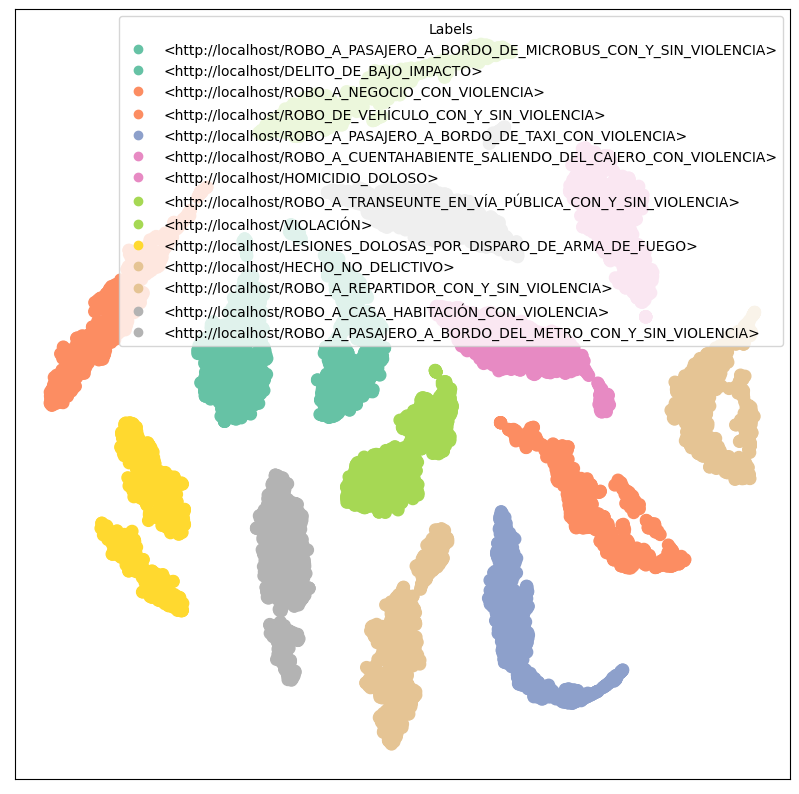

In [86]:
visualize(pred[train_idx], color=to_categorical(train_y), labels=LABELS)

c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\rb_venv3715\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


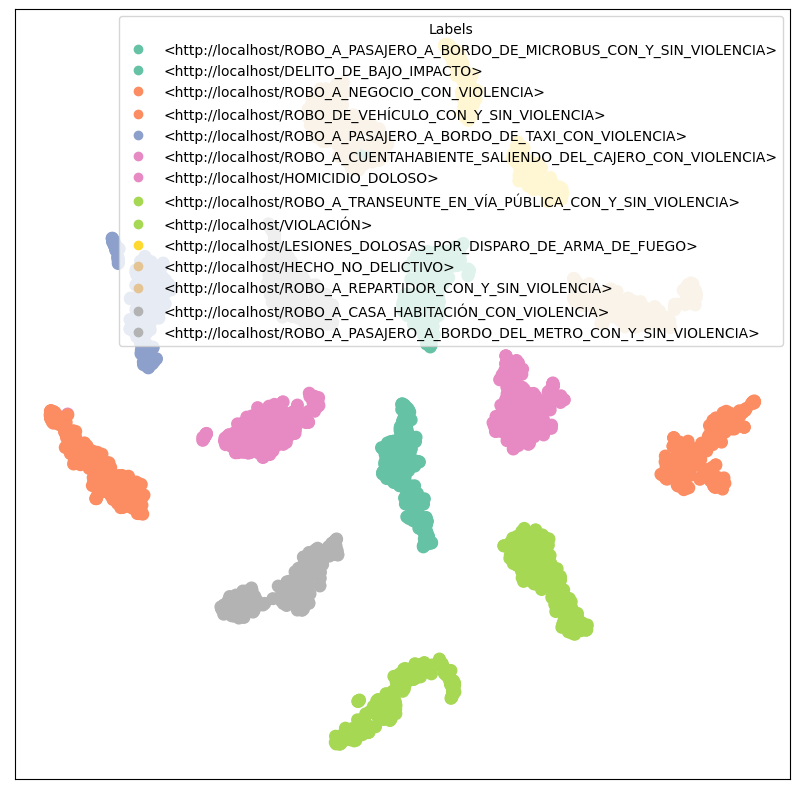

In [87]:
visualize(pred[test_idx], color=to_categorical(test_y), labels=LABELS)

In [88]:
len(pred[test_idx]), len(test_y)

(3499, 3499)

In [89]:
def find(tensor, values):
    return torch.nonzero(tensor[..., None] == values)

In [90]:
test_idx_t = find(node_idx,test_idx)[:,0] ; len(test_idx)

3499

In [91]:
index_t = torch.zeros(node_idx.shape[0], dtype=bool)
index_t[test_idx_t] = True
idx_t = node_idx[index_t]

In [92]:
uris_t = [sg.inverse_transform(i) for i in idx_t]
predicted_labels_t = [l for l in pred[idx_t]]
# extra
predicted_labels_category = [id2label[torch.argmax(x).item()] for x in predicted_labels_t]


In [93]:
real_labels_category = [test_df[test_df['uri'] == uri_pred]['labels'].values[0][0] for uri_pred in uris_t]

In [94]:
predictions_t = list(zip(uris_t, predicted_labels_t, predicted_labels_category, real_labels_category)) ; predictions_t[0:2]

[('<http://localhost/199431>',
  tensor([0.0365, 0.0569, 0.0677, 0.0533, 0.0262, 0.0371, 0.0598, 0.0353, 0.0872,
          0.0415, 0.0240, 0.3116, 0.0269, 0.0147], grad_fn=<UnbindBackward>),
  '<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>',
  '<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>'),
 ('<http://localhost/343395>',
  tensor([0.0189, 0.2462, 0.0793, 0.0788, 0.0504, 0.0842, 0.0811, 0.0172, 0.0951,
          0.0408, 0.0769, 0.0558, 0.0461, 0.0132], grad_fn=<UnbindBackward>),
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>')]

### Contemos cuantos están bien y cuantos mal

In [95]:
realVsPredList = list()
count = 0
for prediction_t in predictions_t:
    realVsPredList.append(prediction_t[2] == prediction_t[3])
    if prediction_t[2] == prediction_t[3]:
        count += 1


In [98]:
count, len(predictions_t)

(3451, 3499)

In [97]:
predictions_t

[('<http://localhost/199431>',
  tensor([0.0365, 0.0569, 0.0677, 0.0533, 0.0262, 0.0371, 0.0598, 0.0353, 0.0872,
          0.0415, 0.0240, 0.3116, 0.0269, 0.0147], grad_fn=<UnbindBackward>),
  '<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>',
  '<http://localhost/ROBO_A_REPARTIDOR_CON_Y_SIN_VIOLENCIA>'),
 ('<http://localhost/343395>',
  tensor([0.0189, 0.2462, 0.0793, 0.0788, 0.0504, 0.0842, 0.0811, 0.0172, 0.0951,
          0.0408, 0.0769, 0.0558, 0.0461, 0.0132], grad_fn=<UnbindBackward>),
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>'),
 ('<http://localhost/286585>',
  tensor([0.0239, 0.2556, 0.0440, 0.1011, 0.0725, 0.0965, 0.0539, 0.0279, 0.0867,
          0.0161, 0.0632, 0.0347, 0.0274, 0.0282], grad_fn=<UnbindBackward>),
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>',
  '<http://localhost/DELITO_DE_BAJO_IMPACTO>'),
 ('<http://localhost/733965>',
  tensor([0.0378, 0.0154, 0.0145, 0.1804, 0.0839, 0.0610, 0.0829, 0.2771, 0.0389,

In [ ]:
# hay que aseguranos que todas las categorias estén presentes en ambos datasets
# Por qué hay muchs nans
# Hacer un conteo de categrias por dataset
# asegurarnos que el split consderve esa relaciónde categorias
# C:\Users\zacat\OneDrive\Documentos\Investigacion\Rubrix prueba\prueba_crimenes3\kglab_pytorch_crimenes.ipynb

### 26/Enero/2023
### Abstract del call for papers
### Averiguar porque están eliminando 6k aristas con el algoritmo k-Hop --> **Probar con varios {k's, capas, dropout}**
### Averiguar cómo situa los puntos en la imagen. Qué significa que estén más cerca o lejos.
#### El algoritmo usado en este ejemplo es t-SNE. El objectivo de este algoritmo es la visualización de datos que están en "altas dimensiones". ¿Cómo? convierte afinidades de puntos de datos en probabilidades. En el "embedded" space las afinidades son representadas mediante la distribución t-student. (https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)
#### TODO: Checar si para alguna categoría funciona mejor el clasificador.
#### TODO: Empezar a checar otros algoritmos clásicos de clasificación.


---
### 2 febrero 2023
### Abstract del call for papers --> Solo considerando RGNN
### Averiguar porque están eliminando 6k aristas con el algoritmo k-Hop --> **Probar con varios {k's, capas, dropout}**
### Quitar atributo contiene y agregarle un caracter extra al atributo